In [1]:
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.interpolate import griddata
from photutils.aperture import *
from scipy.ndimage import gaussian_filter
from scipy.spatial import *
from sklearn.neighbors import KDTree
from astropy.table import Table
from astropy.table import vstack as vstack_table

from skimage.restoration import denoise_tv_bregman
from scipy.signal import convolve2d
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools


from astropy.modeling.models import Gaussian2D
from skimage import color, data, restoration
from mpl_toolkits.axes_grid1 import make_axes_locatable


import re
from os import path
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from collections import Counter
from image_registration import chi2_shift
from my_utils import *
#import naturalneighbor
#import _ngl
#from photutils.aperture import aperture_photometry
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
#from matplotlib.nxutils import points_inside_poly
from matplotlib.path import Path as mpl_path

import Py3D
from Py3D.functions.rssMethod import *
from Py3D.functions.cubeMethod import *



1.1.1


In [2]:
def do_kdtree_n(X):
    mytree = KDTree(X)    
    dist, ind = mytree.query(X[:1], k=3)
    print(dist,ind)
    return np.array(dist),np.array(ind)

def do_kdtree(combined_x_y_arrays,points,k=1):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,k=k)
    return np.array(dist),np.array(indexes)

def weighted_median(data, weights):
    """
    Args:
      data (list or numpy.array): data
      weights (list or numpy.array): weights
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [3]:
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools

def unique2d(a):
    x, y = a.T
    b = x + y*1.0j 
    idx = np.unique(b,return_index=True)[1]
    return a[idx] 

def areaPoly(points):
    area = 0
    nPoints = len(points)
    j = nPoints - 1
    i = 0
    for point in points:
        p1 = points[i]
        p2 = points[j]
        area += (p1[0]*p2[1])
        area -= (p1[1]*p2[0])
        j = i
        i += 1

    area /= 2
    return area

def centroidPoly(points):
    nPoints = len(points)
    x = 0
    y = 0
    j = nPoints - 1
    i = 0

    for point in points:
        p1 = points[i]
        p2 = points[j]
        f = p1[0]*p2[1] - p2[0]*p1[1]
        x += (p1[0] + p2[0])*f
        y += (p1[1] + p2[1])*f
        j = i
        i += 1

    area = areaPoly(hull_points)
    f = area*6
    return [x/f, y/f]

def inter_map_IDW(phot_table_in,radius,crpix,cdelt,dim,\
                  mode='inverseDistance', sigma=1.0, radius_limit=5, \
                  resolution=1.0, min_fibers=3, slope=2.0, bad_threshold=0.1):
    phot_table=phot_table_in.copy()
    img = np.zeros([dim[1],dim[0]],dtype=np.float32)
    weights = np.zeros([dim[1],dim[0]], dtype=np.float32)
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    phot_table['aperture_sum']=phot_table['aperture_sum']/(np.pi*radius**2)
    for phot_now in phot_table:
        if (phot_now['aperture_sum']>0):
            try:
                dist = np.sqrt((phot_now['xcenter']-xi)**2+(phot_now['ycenter']-yi)**2)
            except:
                dist = np.sqrt((phot_now['xcenter'].value-xi)**2+(phot_now['ycenter'].value-yi)**2)
            weights_0= np.exp(-0.5*np.power(dist/sigma,slope))
            weights_0[dist>radius_limit]=0
            img_0 = weights_0*phot_now['aperture_sum']#/(np.pi*radius_now**2)
            img += img_0
            weights += weights_0
            #print(phot_now['aperture_sum'],np.max(img_0),np.max(img))

    mask = (weights>0)  
    img[mask]=img[mask]/weights[mask]
#    img=gaussian_filter(img, sigma=0.25*resolution)
    return img,weights

def inter_cube_IDW(pos_table_x,pos_table_y,RSS,radius,crpix,cdelt,dim,\
                  mode='inverseDistance', sigma=1.0, radius_limit=5, \
                  resolution=1.0, min_fibers=3, slope=2.0, bad_threshold=0.1):
    cube = np.zeros([dim[2],dim[1],dim[0]],dtype=np.float32)
    weights = np.zeros([dim[1],dim[0]], dtype=np.float32)
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    RSS=RSS/(np.pi*radius**2) # Flux is now in units of spaxel    
    for i,(pos_x,pos_y) in enumerate(zip(pos_table_x,pos_table_y)):
        if (np.nanmean(RSS)>0):
            dist = np.sqrt((pos_x-xi)**2+(pos_y-yi)**2)
            weights_0= np.exp(-0.5*np.power(dist/sigma,slope))
            weights_0[dist>radius_limit]=0
            cube_0 = np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)*weights_0
            #print(cube_0.shape)
            cube_0_T = cube_0.T*RSS[i,:]
            #print(cube_0_T.shape)
            cube_0=cube_0_T.transpose(2,1,0)
            #print(cube_0.shape)
            cube += cube_0
            weights += weights_0
            print(f'{i}', end="\r")
            #print(phot_now['aperture_sum'],np.max(img_0),np.max(img))
    cube_weights=np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)
    cube_weights=cube_weights*weights
    mask = (cube_weights>0)  
    cube[mask]=cube[mask]/cube_weights[mask]
#    img=gaussian_filter(img, sigma=0.25*resolution)
    return cube,weights
    
def inter_map(phot_table_in,radius,crpix,cdelt,dim,method='cubic'):
    phot_table=phot_table_in.copy()
    xi = crpix[0]+cdelt[0]*np.arange(0,dim[0])
    yi = crpix[1]+cdelt[1]*np.arange(0,dim[1])
    xi,yi = np.meshgrid(xi,yi)
    phot_table['aperture_sum']=phot_table['aperture_sum']/(np.pi*radius**2)
    img = griddata((phot_table['xcenter'].value, phot_table['ycenter'].value),\
                   phot_table['aperture_sum'].value, (xi, yi),method=method)
    img=gaussian_filter(img, sigma=0.25)
    return img


#  linear_interp = scipy.interpolate.griddata(known_points, known_values, tuple(grid), method='linear')

#    nn_interp = naturalneighbor.griddata(known_points, known_values, grid_ranges)




def bilinear_interpolation(x,y,x_,y_,val):

    a = 1 /((x_[1] - x_[0]) * (y_[1] - y_[0]))
    xx = np.array([[x_[1]-x],[x-x_[0]]],dtype='float32')
    f = np.array(val).reshape(2,2)
    yy = np.array([[y_[1]-y],[y-y_[0]]],dtype='float32')
    b = np.matmul(f,yy)

    return a * np.matmul(xx.T, b)       



def Gaussian2D_map(nx,ny,A,xc,yc,sigma_x,sigma_y,theta=0):
    xi = np.arange(0,nx)
    yi = np.arange(0,ny)
    xi,yi = np.meshgrid(xi,yi)    
    img = Gaussian2D(A, xc, yc, sigma_x, sigma_y, theta=theta)(xi, yi)
    return img

def plot_three(img_in,img_now,res):
    fig,ax = plt.subplots(1,3,figsize=(10,8))
    #plt.subplot(ax[0],projection=wcs)
    ax[0].imshow(np.log10(img_in), cmap='magma_r', vmin=-3, vmax=-0.5, origin='lower')
    #plt.subplot(ax[1],projection=wcs)
    ax[1].imshow(np.log10(img_now), cmap='magma_r', vmin=-3, vmax=-0.5, origin='lower')
    #plt.subplot(ax[2],projection=wcs)
    std=np.nanstd(res)
    im=ax[2].imshow(res/img_in, cmap='coolwarm', vmin=-1, vmax=1, origin='lower')


#    ax[0].set_xlim([0.2*nx,0.8*nx])
#    ax[0].set_ylim([0.2*ny,0.8*ny])

#    ax[1].set_xlim([0.2*nx,0.8*nx])
#    ax[1].set_ylim([0.2*ny,0.8*ny])

#    ax[2].set_xlim([0.2*nx,0.8*nx])
#    ax[2].set_ylim([0.2*ny,0.8*ny])
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im,cax=cax)
#    plt.tight_layout()
    plt.show()


def get_FWHM_conv(img_test,img_ref,FWHM_ref_arc=1,pix_size=1,plot=0):
    diff_min=1e12
    sigma_min=0.1
    for sigma in arange(0.2,10,0.1):
        s_img = gaussian_filter(hdu.data,sigma=sigma)
        diff = img_test-s_img
        d=img_test.shape
        mean_diff = np.sum(np.abs(diff[img_test>0]/img_test[img_test>0])**2)/(d[0]*d[1])
        if (mean_diff<diff_min):
            diff_min=mean_diff
            sigma_min=sigma
    FWHM_PS = FWHM_ref_arc
    FWHM_final = np.sqrt(FWHM_PS**2+sigma_min*pix_size*2.354)
    print('sigma_min_pix=',sigma_min,', sigma_min_arc=',sigma_min*pix_size)
    print('Final FWHM [arcsec] = ', FWHM_final)
    if (plot==1):
        s_img = gaussian_filter(hdu.data,sigma=sigma_min)
        plot_three(s_img,img_test,s_img-img_test)
    return FWHM_final,sigma_min

def deconv_img(img_center,aper_center,FWHM_input=1,slope=0.75,smooth=0,clip=True,filter_epsilon=0.005):
    sigma_FWHM=FWHM_input/pix_size/2.354
    (ny,nx)=img_center.shape
    img_Gauss=Gaussian2D_map(nx,ny,1,nx*0.5,ny*0.5,sigma_FWHM,sigma_FWHM,0)
    phot_Gauss = aperture_photometry(img_Gauss, aper_center,\
                                           method='subpixel',subpixels=5)
    img_Gauss_r,weights_Gauss_r = inter_map_IDW(phot_Gauss,radius,[0,0],[1,1],[nx,ny],slope=slope,\
                                                radius_limit=0.5*5/pix_size)
    img_psf_r = img_Gauss_r[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)]
    img_loop_in = img_center+img_center.max() * 1E-5 * np.random.random(img_center.shape)
    img_loop_dec = restoration.richardson_lucy(img_loop_in, img_psf_r,10,\
                                               clip=clip,filter_epsilon=filter_epsilon)#, num_iter=30)
    if (smooth==1):
        img_loop_dec = gaussian_filter(img_loop_dec,sigma=FWHM_input/pix_size/2.354)#*np.sum(img_Gauss)
    flux_ratio = np.sum(img_center)/np.sum(img_loop_dec)
    img_loop_dec = img_loop_dec*flux_ratio
    img_loop_dec[img_center==0]=0
    return img_loop_dec

def deconv_get_psf(img_center,aper_center,FWHM_input=1):
    (ny,nx)=img_center.shape
    img_Gauss=Gaussian2D_map(nx,ny,1,nx*0.5,ny*0.5,sigma_FWHM,sigma_FWHM,0)
    phot_Gauss = aperture_photometry(img_Gauss, aper_center,\
                                           method='subpixel',subpixels=5)
    img_Gauss_r,weights_Gauss_r = inter_map_IDW(phot_Gauss,radius,[0,0],[1,1],[nx,ny],slope=slope,\
                                                radius_limit=0.5*5/pix_size)
    img_psf_r = img_Gauss_r[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)]
    return img_psf_r

def deconv_img_psf(img_center,img_psf,FWHM_input=1,smooth=0,clip=True,filter_epsilon=0.005):
    sigma_FWHM=FWHM_input/pix_size/2.354
    (ny,nx)=img_center.shape
    img_loop_in = img_center+img_center.max() * 1E-5 * np.random.random(img_center.shape)
    img_loop_dec = restoration.richardson_lucy(img_loop_in, img_psf_r,10,\
                                               clip=clip,filter_epsilon=filter_epsilon)#, num_iter=30)
    if (smooth==1):
        img_loop_dec = gaussian_filter(img_loop_dec,sigma=FWHM_input/pix_size/2.354)#*np.sum(img_Gauss)
    flux_ratio = np.sum(img_center)/np.sum(img_loop_dec)
    img_loop_dec = img_loop_dec*flux_ratio
    img_loop_dec[img_center==0]=0
    return img_loop_dec

In [4]:
def get_astrometry(img,filename_PS,name='NGC5947', ext='pdf', xc_PS=248.526778723309, yc_PS=249.418413876343, RA_PS=232.652436800918, DEC_PS=42.7171665852056, xc_cal=42.5, yc_cal=35.5, band='r',i_range=5, plot=1,new_pix=0.5,label='',FWHM_in=1,A_R=0.0, flux_lim=0.02):
#    filename_PS = f'{name}_PS_warp_{band}.fits'
#    filename_cal = f'out/map.r.{name}.fits'
#    print(filename_PS)
    f_cor=1.0
    ww = {'g': 4866, 'r': 6215, 'i': 7545, 'z': 8679, 'y': 9633}
    ww_now = ww[band]
    if (path.exists(filename_PS)):
        fname=f'astro_{name}_{band}_new.{ext}'
        hdu_PS = fits.open(filename_PS)[0]
        hdu_PS_org=hdu_PS.copy()
        (ny_PS,nx_PS)=hdu_PS.data.shape
        EXPTIME = hdu_PS.header['EXPTIME']
        wcs_copy = WCS(hdu_PS.header)
        print(f'CDELT_ORG = {wcs_copy.wcs.cdelt}')
        pix_rat = np.abs(wcs_copy.wcs.cdelt[0]*3600)
        f_ratio = ((10**(-6.64))/EXPTIME)*(((1e-23)*(3e18))/ww_now**2)*1e16/pix_rat**2
        (ny_PS,nx_PS)=hdu_PS.data.shape
        xc_PS = nx_PS/2.0
        yc_PS = ny_PS/2.0 
        hdu_PS.data=hdu_PS.data*10**(0.4*A_R)
        hdu_PS_org.data=hdu_PS_org.data*10**(0.4*A_R)
        print('xc_PS=',xc_PS,yc_PS, int(1.2*xc_PS),int(1.2*yc_PS))
        img_cut_PS =  Cutout2D(hdu_PS.data.astype(np.float32),\
                               (int(xc_PS),int(yc_PS)), (int(1.2*xc_PS),int(1.2*yc_PS)),wcs=wcs_copy)
        w=img_cut_PS.wcs
        header = w.to_header()
        hdu_PS = fits.PrimaryHDU(header=header)
        hdu_PS.data=img_cut_PS.data
        wcs_copy = WCS(hdu_PS.header)
        mag_PS = -2.5*np.log10(np.nansum(hdu_PS.data))+25+2.5*np.log10(EXPTIME)
        hdu_PS.data=hdu_PS.data*f_ratio
        hdu_PS_org.data=hdu_PS_org.data*f_ratio
#        plt.imshow(np.log10(img))
#        plt.show()
        
        print(f'flux_ratio = {f_ratio}')
        (ny_PS,nx_PS)=hdu_PS.data.shape
        wcs = WCS(hdu_PS.header)

        
        hdu = fits.PrimaryHDU(img)
        xc_cal=xc_cal-0.5
        yc_cal=yc_cal-0.5
        x_list = np.arange(0,nx_PS)
        y_list = np.arange(0,ny_PS)
        xx_list, yy_list = np.meshgrid(x_list, y_list)
        map_dist_PS = np.sqrt((xx_list-xc_PS)**2+(yy_list-yc_PS)**2)
        hdu_dist_PS = fits.PrimaryHDU(header=header)
        hdu_dist_PS.data=map_dist_PS

        (ny_cal,nx_cal)=hdu.data.shape
        hdu.data=hdu.data/(new_pix**2)/f_cor
        x_list = np.arange(0,nx_cal)
        y_list = np.arange(0,ny_cal)
        xx_list, yy_list = np.meshgrid(x_list, y_list)
        map_dist_CAL = np.sqrt((xx_list-nx_cal/2)**2+(yy_list-ny_cal/2)**2)
        crpix1_cal=np.int(xc_cal)+1
        crpix2_cal=np.int(yc_cal)+1
        d_crval1=new_pix*((xc_cal+1)-crpix1_cal)/3600.0
        d_crval2=new_pix*((yc_cal+1)-crpix2_cal)/3600.0
        crval1_cal=RA_PS+d_crval1
        crval2_cal=DEC_PS-d_crval2
        flux_CAL = np.nansum(hdu.data)
        flux_val = (((np.nansum(hdu.data[hdu.data>0]))*(ww_now**2))/((1e-23)*(3e18)))*1e-16
        mag_CAL = 8.4-2.5*np.log10(flux_val)
        #
        # Update the header with the new wcs!
        #
        (nx,ny)=hdu.data.shape
        wcs_cal = WCS(naxis=2)
        print('WCS_input=',crpix1_cal,crpix2_cal)
        wcs_cal.wcs.crpix = [crpix1_cal,crpix2_cal]
        wcs_cal.wcs.cdelt = np.array([-new_pix/3600,new_pix/3600])
        wcs_cal.wcs.crval = [crval1_cal, crval2_cal]
        wcs_cal.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        hdu.header=wcs_cal.to_header()
        #
        #
        #        
        img_PS_to_CAL, footprint_PS_to_CAL = reproject_interp(hdu_PS, hdu.header)
#        plt.imshow(np.log10(img_PS_to_CAL.data))
#        plt.show()
#        plt.imshow(np.log10(hdu.data))
#        plt.show()
        mag_PS_to_CAL = -2.5*np.log10(np.nansum(img_PS_to_CAL/f_ratio/(pix_rat**2)))+25+2.5*np.log10(EXPTIME)
        print("IN= ",crval1_cal,crval2_cal)
        d_shift=0.3        
        for i in range(i_range):
            img_PS_to_CAL_input, footprint_PS_to_CAL = reproject_interp(hdu_PS, hdu.header)
            img_PS_to_CAL=gaussian_filter(img_PS_to_CAL_input, sigma=1.0)
            xoff, yoff, exoff, eyoff = chi2_shift(img_PS_to_CAL, hdu.data, err=map_dist_CAL/30,
                                                  return_error=True, upsample_factor='auto')#,boundary='wrap')
            if ((np.abs(xoff)<10) and (np.abs(yoff)<10) and (np.abs(eyoff)<10) and (np.abs(eyoff)<10)):
#                print('Offsets (',i,'):  x= ',xoff,'+-',exoff,' y= ',yoff,'+-',eyoff)
                crval1_cal=crval1_cal-xoff*(-new_pix/3600)
                crval2_cal=crval2_cal-yoff*(new_pix/3600)
                e_crval1_cal=exoff*(-new_pix/3600)
                e_crval2_cal=eyoff*(new_pix/3600)
                wcs_cal.wcs.crval = [crval1_cal, crval2_cal]
                hdu.header=wcs_cal.to_header()
            else:
                e_crval1_cal=exoff*(-new_pix/3600)
                e_crval2_cal=eyoff*(new_pix/3600)
        print("OUT = ",crval1_cal,crval2_cal)
        if (filename_PS.find("_PS_")):
            print('photometric correction')
            pix_rat = np.abs(wcs_copy.wcs.cdelt[0]/(new_pix/3600))
            print(f'pix_rat = {pix_rat}')
            rat_data=hdu.data/img_PS_to_CAL#(pix_rat)#/hdu.data
#            plt.imshow(hdu.data)
            mask_data= (hdu.data>0.001)
            print(len(rat_data[mask_data]))
            rat_mean=weighted_median(rat_data[mask_data],1/(1+map_dist_CAL[mask_data]))
            rat_std=np.nanstd(rat_data[mask_data])
            print(f'rat = {rat_mean}+-{rat_std}')

        
        #wcs_cal = WCS(hdu.header)    
        
        print(f'filter={band}, mag_PS = {mag_PS}, mag_PS_to_CAL = {mag_PS_to_CAL}, mag_CAL = {mag_CAL}')
        mask_now = (hdu.data>flux_lim) & (img_PS_to_CAL>flux_lim)
        n_mask=mask_data.sum()
        sigma_now = 1
        if (n_mask>10):
            sigma_list=[]
            chi_list=[]
            for sigma in np.arange(0.1,3.3,0.05):
                img_PS_to_CAL=gaussian_filter(img_PS_to_CAL_input*rat_mean, sigma=sigma)
                #chi_map = (np.sinh(img_PS_to_CAL)-np.sinh(hdu.data))**2/np.sinh(hdu.data)
                chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data
                chi_now = np.nansum(chi_map[mask_now])
                sigma_list.append(sigma)
                chi_list.append(chi_now)
            sigma_list=np.array(sigma_list)
            chi_list=np.array(chi_list)
            sigma_now=sigma_list[np.argmin(chi_list)]
            chi_now=chi_list[np.argmin(chi_list)]
        #print(sigma_list,chi_list)
        print(f'sigma_psf = {sigma_now} pixels, chi_min={chi_now}')
        #FWHM_now = np.sqrt((2.354*sigma_now*new_pix)**2+FWHM_in)
        FWHM_now = 2.354*new_pix*np.sqrt((sigma_now)**2+(FWHM_in/2.354)**2)
        img_PS_to_CAL_input, footprint_PS_to_CAL = reproject_interp(hdu_PS_org, hdu.header)
        img_PS_to_CAL=gaussian_filter(img_PS_to_CAL_input*rat_mean, sigma=sigma_now)
        rat_data=hdu.data/img_PS_to_CAL
        print(f'FWHM_now = {FWHM_now} arcsec')
        #------ PLOT ------ #
        vmin=-3
        vmax=0.05
        if (plot==1):
            fig=plt.figure(figsize=(15,8))
            gs = fig.add_gridspec(2,3)
            ax=fig.add_subplot(gs[0,0],projection=wcs_copy)
            ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
            ax.set_title('PANStarr')
            ax.set_xlabel('R.A.')
            ax.set_ylabel('Dec')
            ax.scatter(xc_PS,yc_PS, s=15,  edgecolor='blue', facecolor='blue') 
            ax3=fig.add_subplot(gs[1,0],projection=wcs_cal)
            ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')        
            ax2=fig.add_subplot(gs[0,1],projection=wcs_cal)
            ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
            ax2.contour(hdu_PS.data, levels=np.logspace(-2, 0.15, 5), colors='blue', alpha=0.5, transform=ax2.get_transform(WCS(hdu_PS.header)))
            ax2.scatter(xc_cal, yc_cal, s=20, edgecolor='white', facecolor='white')
            ax2.scatter(RA_PS, DEC_PS, s=10, transform=ax2.get_transform('fk5'),  edgecolor='blue', facecolor='blue')
            ax2.set_title('CALIFA: '+name)
            ax2.set_xlabel('R.A.')
            ax2.set_xlim(-0.5, hdu.data.shape[1] - 0.5)
            ax2.set_ylim(-0.5, hdu.data.shape[0] - 0.5)
            ax.contour(hdu.data, levels=np.logspace(-2, 0.15, 5), colors='red', alpha=0.5, transform=ax.get_transform(wcs_cal))
            ax3.contour(hdu.data, levels=np.logspace(-2, 0.15, 5), colors='red', alpha=0.5, transform=ax3.get_transform(wcs_cal))
            ax3.scatter(RA_PS, DEC_PS, s=10, transform=ax3.get_transform('fk5'),  edgecolor='blue', facecolor='blue')
            ax3.set_title('PS resampled to CALIFA: '+name)
            ax3.set_xlabel('R.A.')
            ax3.set_ylabel('Dec')
            ax.set_xlim(-0.5, hdu_PS.data.shape[1] - 0.5)
            ax.set_ylim(-0.5, hdu_PS.data.shape[0] - 0.5)
            ax.contour(hdu.data, levels=np.logspace(-2, 0.15, 5), colors='red', alpha=0.25, transform=ax.get_transform(wcs_cal))
            ax4=fig.add_subplot(gs[1,1],projection=wcs_cal)
            fig_img=ax4.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
            ax4.contour(hdu.data, levels=np.logspace(-2, 0.15, 5), colors='red', alpha=0.5, transform=ax4.get_transform(wcs_cal),lw=3,label='CALIFA')
            ax4.contour(img_PS_to_CAL, levels=np.logspace(-2, 0.15, 5), colors='blue', alpha=0.5, transform=ax4.get_transform(wcs_cal),label='PanStarrs')
            ax4.scatter(xc_cal, yc_cal, s=20, edgecolor='white', facecolor='white')
            ax4.scatter(RA_PS, DEC_PS, s=10, transform=ax4.get_transform('fk5'),  edgecolor='blue', facecolor='blue')#,label='PanStarrs')
            ax4.set_title('WCS registration'+name)
            ax4.set_xlabel('R.A.')
            ax4.set_xlim(-0.5, hdu.data.shape[1] - 0.5)
            ax4.set_ylim(-0.5, hdu.data.shape[0] - 0.5)
            if (filename_PS.find("_PS_")):
                ax5=fig.add_subplot(gs[0,2])
                ax5.set_title(label)
                ax5.scatter(np.log10(hdu.data[mask_data]),rat_data[mask_data],\
                            edgecolor='none',color='black',alpha=0.2)
                ax5.set_ylim([0,2])
            ax6=fig.add_subplot(gs[1,2],projection=wcs_cal)
            fig_res=ax6.imshow(rat_data, cmap='gray_r', vmin=0.5, vmax=1.5, origin='lower')
            ax6.contour(hdu_PS.data, levels=np.linspace(1, 5, 5), colors='blue', alpha=0.5,\
                        transform=ax4.get_transform(WCS(hdu_PS.header)))
            ax6.scatter(xc_cal, yc_cal, s=20, edgecolor='white', facecolor='white')
            ax6.scatter(RA_PS, DEC_PS, s=10, transform=ax4.get_transform('fk5'),  edgecolor='blue', facecolor='blue')
            ax6.set_title('WCS registration'+name)
            ax6.set_xlabel('R.A.')
            ax6.set_xlim(-0.5, hdu.data.shape[1] - 0.5)
            ax6.set_ylim(-0.5, hdu.data.shape[0] - 0.5)
            fig.tight_layout()
            fig.savefig(fname,dpi=150)
#---------- END PLOT ----------#        
        return (crval1_cal,crval2_cal,crpix1_cal,crpix2_cal,e_crval1_cal,e_crval2_cal,rat_mean,rat_std,mag_PS, mag_PS_to_CAL, mag_CAL,FWHM_now,chi_now,rat_data)


In [5]:
def plot_four(img_in,phot_table,img,img_loop):
    fig,ax = plt.subplots(2,2,figsize=(10,8))
    try:
        plt.subplot(ax[0][0],projection=wcs)
    except:
        print('no WCS')
    ax[0][0].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')
    try:
        plt.subplot(ax[1][0],projection=wcs)
    except:
        print('no WCS')
    ax[0][1].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=-3, origin='lower')
    cm = plt.cm.get_cmap('Greys')
    ax[0][1].scatter(phot_table['xcenter'],phot_table['ycenter'],\
                     c=np.log10(phot_table['aperture_sum']/(np.pi*radius**2)),\
                     cmap=cm, vmin=-3, vmax=0.15,\
                     s=140)
    try:
        plt.subplot(ax[1][0],projection=wcs)
    except:
        print('no WCS')
    ax[1][0].imshow(np.log10(img), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')
    try:
        plt.subplot(ax[1][1],projection=wcs)
    except:
        print('no WCS')
    ax[1][1].imshow(np.log10(img_loop), cmap='gray_r', vmin=-3, vmax=0.05, origin='lower')


    ax[0][0].set_xlim([0*nx,1.0*nx])
    ax[0][0].set_ylim([0*ny,1.0*ny])

    ax[0][1].set_xlim([0*nx,1.0*nx])
    ax[0][1].set_ylim([0*ny,1.0*ny])

    ax[1][0].set_xlim([0*nx,1.0*nx])
    ax[1][0].set_ylim([0*ny,1.0*ny])

    ax[1][1].set_xlim([0*nx,1.0*nx])
    ax[1][1].set_ylim([0*ny,1.0*ny])
    
    
def plot_three(img_in,img_now,res):
    fig,ax = plt.subplots(1,3,figsize=(10,8))
    #plt.subplot(ax[0],projection=wcs)
    ax[0].imshow(np.log10(img_in), cmap='gray_r', vmin=-3, vmax=0.15, origin='lower')
    #plt.subplot(ax[1],projection=wcs)
    ax[1].imshow(np.log10(img_now), cmap='gray_r', vmin=-3, vmax=0.15, origin='lower')
    #plt.subplot(ax[2],projection=wcs)
    std=np.nanstd(res)
    ax[2].imshow(res/img_in, cmap='gray_r', vmin=-2, vmax=2, origin='lower')


    ax[0].set_xlim([0.2*nx,0.8*nx])
    ax[0].set_ylim([0.2*ny,0.8*ny])

    ax[1].set_xlim([0.2*nx,0.8*nx])
    ax[1].set_ylim([0.2*ny,0.8*ny])

    ax[2].set_xlim([0.2*nx,0.8*nx])
    ax[2].set_ylim([0.2*ny,0.8*ny])
    plt.show()


In [6]:
name = 'NGC2906'
fdir = 'data'
fdir_out = 'out'
file_rss = f'{fdir}/{name}.mos.V500.rss.fits.gz'
hdu_rss=fits.open(file_rss)

In [7]:
rss_data=hdu_rss[0].data
#rss_data=nan_to_num(rss_data, nan=0.0)
plt.show()
rss_err=hdu_rss['ERROR'].data
rss_bad=hdu_rss['BADPIX'].data
tab_rss=Table(hdu_rss['POSTABLE'].data)
fsize=2.68/2
radius=fsize
(ny_rss,nx_rss)=rss_data.shape
wavelength=hdu_rss[0].header['CRVAL1']+hdu_rss[0].header['CDELT1']*(arange(0,nx_rss))

In [8]:
#
# Refine the error map
#
med_err = np.nanmedian(rss_err)
std_err = np.nanstd(rss_err[rss_err<3*med_err])
rss_err[rss_err>(med_err+3*std_err)]=med_err


In [9]:
#primhdu = fits.PrimaryHDU(data=rss_err_new)
#hdulist=fits.HDUList([primhdu])
#outfile=f'out/{name}.rss_err_new.fits.gz'
#hdulist.writeto(outfile,overwrite=True)


In [10]:
print(tab_rss.columns)

<TableColumns names=('X_Position','Y_Position','GoodFiber','FiberType')>


In [11]:
pt_file=f'{fdir}/{name}.mos.V500.pt.txt'
#pt_file="/home/sanchez/tmp/web_20181105/UGC02225.mos.V500.pt.txt"#UGC02225.mos.V500.pt.txt"
#pt_file="/disk-a/sanchez/ppak/legacy/DATA/SSP/legacy/mos_new.pt.txt"
with open(pt_file) as fp:
    line = fp.readline()
    pt_shape=line.split()
    pt_x=[]
    pt_y=[]
    while line:
        line = fp.readline()
        pt_pos = line.split()
        if (len(pt_pos)>0):
            pt_x.append(float(pt_pos[1]))
            pt_y.append(float(pt_pos[2]))

pt_x=np.array(pt_x)
pt_y=np.array(pt_y)
#print(pt_x,pt_y)
print(len(pt_x))
#print(pt_x)   
points=np.zeros((len(pt_x),2))
points[:,0]=pt_x
points[:,1]=pt_y


x_min = np.min(pt_x)-2*fsize
x_max = np.max(pt_x)+2*fsize
y_min = np.min(pt_y)-2*fsize
y_max = np.max(pt_y)+2*fsize
pix_size=0.5
nx = int((x_max-x_min)/pix_size)
ny = int((y_max-y_min)/pix_size)
dim = np.array([nx,ny])

pt_x_spax=(pt_x-x_min)/pix_size
pt_y_spax=(pt_y-y_min)/pix_size

points_WCS=points.copy()
points_WCS[:,0]=pt_x_spax
points_WCS[:,1]=pt_y_spax
#
# Based on the simulations
#
slope=1.25
#
#slope=0.75
sigma=pix_size
r_lim=1.5*radius/pix_size
smooth=0

993


In [12]:
#
# We look for those spectra affected by vignetting
#
zero_slice = np.zeros((len(pt_x)))
ind_spec = np.arange(0,len(pt_x))
#print(zero_slice.shape)
for i in arange(0,len(pt_x)):
    #zero_slice[i]=
    zero_slice[i]=rss_data[i,:].tolist().count(0)

mask_vig = (zero_slice>10)
#print(len(zero_slice[mask_vig]))
#print(points[:,0])
nk=6
dist_vig, ind_vig = do_kdtree(points[mask_vig],points[~mask_vig],k=nk)
#print(ind_vig)


In [13]:
#
# We look for those spectra affected by vignetting
#
n_ind_vig=ny_rss
iter_now=0
while (n_ind_vig>0):

    zero_slice = np.zeros((len(pt_x)))
    for i in arange(0,len(pt_x)):
        zero_slice[i]=rss_data[i,:].tolist().count(0)

    mask_vig = (zero_slice>10)
    nk=4
    dist_vig, ind_vig = do_kdtree(points[~mask_vig],points[mask_vig],k=nk)
    ind_spec_vig = ind_spec[mask_vig]
    ind_spec_nvig = ind_spec[~mask_vig]
    for i_vig in arange(len(ind_spec_vig)):
        n_spec_vig=ind_spec_vig[i_vig]
        (ny_rss,nx_rss)=rss_data.shape
        spec_now = rss_data[n_spec_vig,:]
        med=np.nanmedian(spec_now[spec_now!=0])
        max_v=np.nanmax(spec_now[spec_now!=0])
        rss_near=np.zeros([nk,nx_rss],dtype=np.float32)
        weights=[]
        for j in arange(0,nk):
            n_spec_nvig=ind_vig[i_vig,j]
            med_j=np.nanmedian(rss_data[n_spec_nvig,:][spec_now!=0])
            spec_scaled = rss_data[n_spec_nvig,:]*(med/med_j)
            chi_sq = np.nansum(((spec_now-spec_scaled)**2/spec_now)[spec_now!=0])
            weights.append(1/chi_sq)
            rss_near[j,:]=spec_scaled
        weights=np.array(weights)
        spec_near=np.average(rss_near,axis=0,weights=weights)
        spec_now[spec_now==0]=spec_near[spec_now==0]
        rss_data[n_spec_vig,:]=spec_now
    rss_data=nan_to_num(rss_data, nan=0.0)  
    n_ind_vig=len(ind_vig)
    iter_now=iter_now+1
    print(f'cleaning: {iter_now} {n_ind_vig}')

<ipython-input-13-a173de74e204>:29: RuntimeWarning: divide by zero encountered in true_divide
  chi_sq = np.nansum(((spec_now-spec_scaled)**2/spec_now)[spec_now!=0])
<ipython-input-13-a173de74e204>:29: RuntimeWarning: invalid value encountered in true_divide
  chi_sq = np.nansum(((spec_now-spec_scaled)**2/spec_now)[spec_now!=0])
<ipython-input-13-a173de74e204>:30: RuntimeWarning: divide by zero encountered in true_divide
  weights.append(1/chi_sq)
/home/sanchez/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/sanchez/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


cleaning: 1 264
cleaning: 2 2
cleaning: 3 0


In [14]:
#print(len(ind_vig))

In [15]:
#print(len(ind_spec_vig))
#print(len(ind_spec_nvig))
#print(len(ind_vig))

i_vig=0
n_spec_vig=ind_spec_vig[i_vig]

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
(ny_rss,nx_rss)=rss_data.shape
#med=np.nanmedian(rss_data[n_spec_vig,int(nx_rss*0.3):int(nx_rss*0.7)])
#max_v=np.nanmax(rss_data[n_spec_vig,int(nx_rss*0.4):int(nx_rss*0.6)])
spec_now = rss_data[n_spec_vig,:]
med=np.nanmedian(spec_now[spec_now!=0])
max_v=np.nanmax(spec_now[spec_now!=0])
rss_near=np.zeros([nk,nx_rss],dtype=np.float32)
weights=[]
for j in arange(0,nk):
    n_spec_nvig=ind_vig[i_vig,j]
    med_j=np.nanmedian(rss_data[n_spec_nvig,:][spec_now!=0])
    spec_scaled = rss_data[n_spec_nvig,:]*(med/med_j)
    chi_sq = np.nansum(((spec_now-spec_scaled)**2/spec_now)[spec_now!=0])
    weights.append(1/chi_sq)
    rss_near[j,:]=spec_scaled
    ax.plot(wavelength,rss_near[j,:],alpha=0.3,color='orange')
weights=np.array(weights)
spec_near=np.average(rss_near,axis=0,weights=weights)
ax.plot(wavelength,rss_data[n_spec_vig,:],color='grey',linewidth=5)
spec_now[spec_now==0]=spec_near[spec_now==0]
ax.plot(wavelength,spec_near,color='red', linewidth=2)    
ax.plot(wavelength,spec_now,color='black', linewidth=1)    

    
ax.set_xlim(3700,7500)
print(med,max_v)
ax.set_ylim(-0.5*med,1.2*max_v)
#ax.set_ylim(-45,45)
#print(ind_vig)

In [16]:

#print(len(ind_vig))
#print(ind_vig)

#
# Clean Vignetting
#
#i_vig=0
#n_spec_vig=ind_spec_vig[i_vig]
for i_vig in arange(len(ind_spec_vig)):
    n_spec_vig=ind_spec_vig[i_vig]
    (ny_rss,nx_rss)=rss_data.shape
    spec_now = rss_data[n_spec_vig,:]
    med=np.nanmedian(spec_now[spec_now!=0])
    max_v=np.nanmax(spec_now[spec_now!=0])
    rss_near=np.zeros([nk,nx_rss],dtype=np.float32)
    weights=[]
    for j in arange(0,nk):
        n_spec_nvig=ind_vig[i_vig,j]
        med_j=np.nanmedian(rss_data[n_spec_nvig,:][spec_now!=0])
        spec_scaled = rss_data[n_spec_nvig,:]*(med/med_j)
        chi_sq = np.nansum(((spec_now-spec_scaled)**2/spec_now)[spec_now!=0])
        weights.append(1/chi_sq)
        rss_near[j,:]=spec_scaled
    weights=np.array(weights)
    spec_near=np.average(rss_near,axis=0,weights=weights)
    spec_now[spec_now==0]=spec_near[spec_now==0]
    rss_data[n_spec_vig,:]=spec_now
    

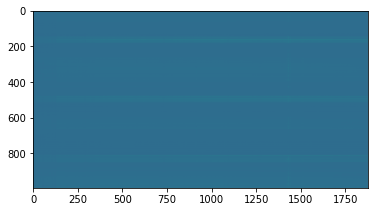

In [17]:
plt.imshow(rss_data)
#rss_data=nan_to_num(rss_data, nan=0.0)
primhdu = fits.PrimaryHDU(data=rss_data,header=hdu_rss[0].header)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.rss_data.fits.gz'
hdulist.writeto(outfile,overwrite=True)


(-45.0, 45.0)

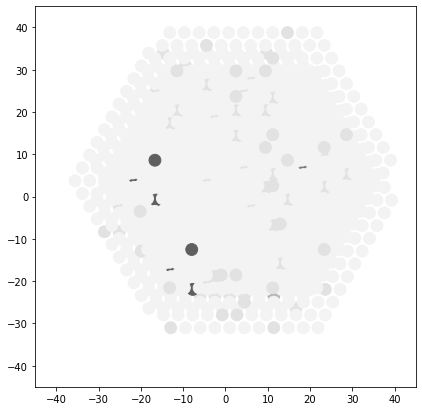

In [18]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cm = plt.cm.get_cmap('Greys')
ax.scatter(pt_x,pt_y,c=zero_slice,\
              cmap=cm, vmin=0, vmax=10,\
             s=140)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-45,45)
ax.set_ylim(-45,45)




In [19]:
#img_org_075,weights = inter_map_IDW(phot_table,radius,[0,0],[1,1],[nx,ny],slope=slope,\
#                            radius_limit=3.5/pix_size)
print(np.nanmean(rss_data))
print(radius)
print(nx,ny,nx_rss)
cube_org,weights_org=inter_cube_IDW(pt_x_spax,pt_y_spax,rss_data,radius,\
                                    [0,0],[1,1],[nx,ny,nx_rss],\
                                    mode='inverseDistance', sigma=sigma, radius_limit=r_lim, 
                                    resolution=1.0, min_fibers=3, slope=slope, bad_threshold=0.1)

0.11081084
1.34
160 150 1877


In [20]:
cube_var,weights_var=inter_cube_IDW(pt_x_spax,pt_y_spax,rss_err**2,radius,\
                                    [0,0],[1,1],[nx,ny,nx_rss],\
                                    mode='inverseDistance', sigma=sigma, radius_limit=r_lim,
                                    resolution=1.0, min_fibers=3, slope=slope, bad_threshold=0.1)

In [21]:
#
# Astrometry and flux recalibration!
#

In [22]:
get_GE="../analysis/tables/get_GALEXT.csv"
col_GE=header_columns_space(get_GE,2)
tab_GE=ascii.read(get_GE, delimiter=',', guess=True, comment='\s*#', names=col_GE,\
                      fill_values=[('BAD', np.nan)])
tab_GE.rename_column('NAME', 'name')
tab_GE.add_column(0.99*tab_GE['GALEXT_V'],name='Ag');
tab_GE.add_column(0.99*tab_GE['GALEXT_V']*3.303/2.285,name='Ar');
tab_GE.add_column(0.99*tab_GE['GALEXT_V']*1.698/2.285,name='Ai');

tab_GE_name=tab_GE[tab_GE['name']==name]
Ar_name = tab_GE_name['Ar'][0]
Ag_name = tab_GE_name['Ag'][0]
print('A_r =',Ar_name)
print('A_g =',Ag_name)


A_r = 0.2232452166301969
A_g = 0.15444


In [23]:
filter_r='/home/sanchez/filters/r.dat'
passband_r = PassBand()
passband_r.loadTxtFile(filter_r, wave_col=1,  trans_col=2)
eff_wave_r=passband_r.effectiveWave()
print(eff_wave_r)
filter_g='/home/sanchez/filters/g.dat'
passband_g = PassBand()
passband_g.loadTxtFile(filter_g, wave_col=1,  trans_col=2)
eff_wave_g=passband_g.effectiveWave()
print(eff_wave_g)
filter_u='/home/sanchez/filters/u.dat'
passband_u = PassBand()
passband_u.loadTxtFile(filter_u, wave_col=1,  trans_col=2)
eff_wave_u=passband_u.effectiveWave()
print(eff_wave_u)


6175.5786
4702.495
3556.524


In [24]:
#
# We get the r-band filter image
#
# 'r': 6215
#wavelength
#idx_r = np.abs(wavelength - 6215).argmin()
#print(idx_r)
#i0=idx_r-100
#i1=idx_r+100
#img_r = np.nanmean(cube_org[i0:i1,:,:],axis=0)

hdr=hdu_rss[0].header.copy()
hdr['CRVAL3']=hdu_rss[0].header['CRVAL1']
hdr['CRPIX3']=hdu_rss[0].header['CRPIX1']
hdr['CDELT3']=hdu_rss[0].header['CDELT1']
hdr['CD1_1']=pix_size/3600
hdr['CD1_2']=0.0
hdr['CD1_3']=0.0
hdr['CD2_1']=0.0
hdr['CD2_2']=pix_size/3600
hdr['CD2_3']=0.0
hdr['CD3_1']=0.0
hdr['CD3_2']=0
hdr['CD3_3']=hdu_rss[0].header['CDELT1']
hdr['CTYPE1']='RA---TAN' 
hdr['CTYPE2']='DEC--TAN' 
hdr['CTYPE3']='WAVELENGTH' 
hdr['CUNIT1']='deg'
hdr['CUNIT2']='deg' 
hdr['CUNIT3']='Angstrom'
cube_cl = Cube(data=cube_org,wave=wavelength,header=hdr)
img_u = passband_u.getFluxCube(cube_cl)[0]
img_g = passband_g.getFluxCube(cube_cl)[0]
img_r = passband_r.getFluxCube(cube_cl)[0]
#print(img_r)
#print(img_r.shape)
#print(img_r.shape,i0,i1)
#print(np.nanmean(cube_org))

0.012944429


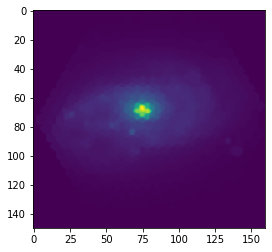

In [25]:
plt.imshow(img_r)
print(np.mean(img_r))

['NGC2906']
CDELT_ORG = [6.94444461e-05 6.94444461e-05]
xc_PS= 240.0 240.0 288 288
flux_ratio = 2.308850823739632e-05
WCS_input= 71 61
IN=  143.02611139053542 8.44126148169516


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/sanchez/.local/lib/python3.8/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]


OUT =  143.0266276123236 8.44051956546252
photometric correction
pix_rat = 0.5000000121071928
17477
rat = 1.009476797872846+-0.26722554094295553
filter=r, mag_PS = 11.91738056899177, mag_PS_to_CAL = 10.41747287948986, mag_CAL = 10.389712164913078
sigma_psf = 2.400000000000001 pixels, chi_min=9.82187167670661
FWHM_now = 2.8464003653737833 arcsec


<ipython-input-4-fdef43e42c54>:131: RuntimeWarning: divide by zero encountered in true_divide
  chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
<ipython-input-4-fdef43e42c54>:154: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:160: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:162: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e

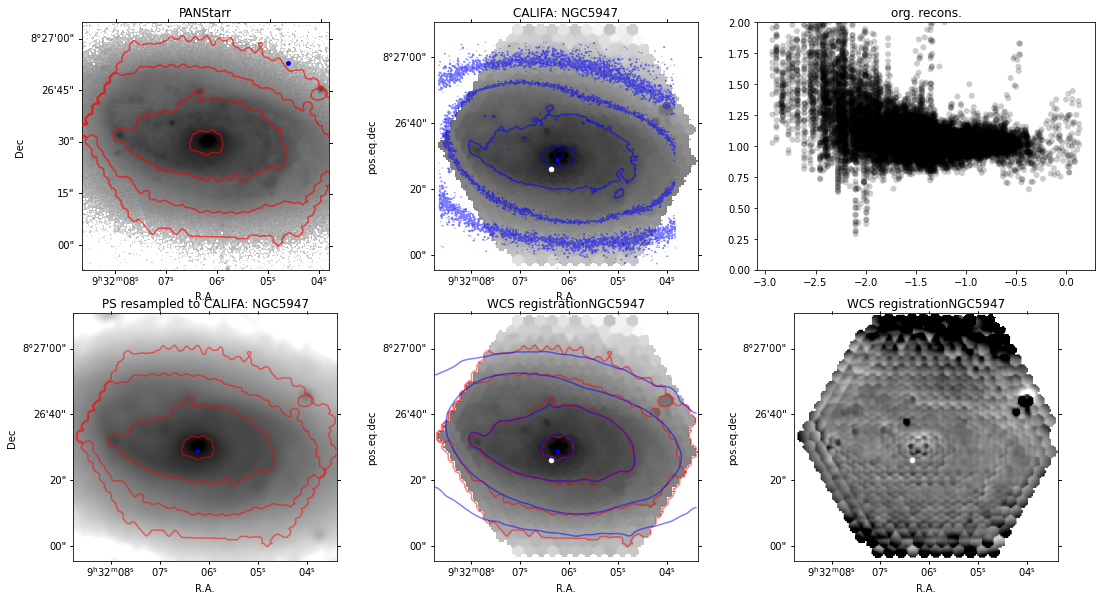

In [26]:
get_astro='../analysis/tables/get_astrometry_cross.warp.csv'
tab_astro=ascii.read(get_astro,fill_values=[('BAD', np.nan)],format='csv')
df_s=tab_astro[tab_astro['name']==name]
print(df_s['name'].value)
ext='png'
band='r'
i_range=5
filename_PS_r = f'{name}_PS_warp_{band}.fits'
(crval1_cal,crval2_cal,\
 crpix1_cal,crpix2_cal,e_crval1_cal,\
 e_crval2_cal,rat_mean,rat_std,mag_PS,\
 mag_PS_to_CAL,mag_CAL,FWHM_now,chi_now,rat_map)=get_astrometry(img_r,filename_PS_r,ext=ext, xc_PS=df_s['XC1'][0],yc_PS=df_s['YC1'][0],RA_PS=df_s['CRVAL1_CR'][0] , DEC_PS=df_s['CRVAL2_CR'][0], xc_cal=df_s['XC'][0]/pix_size-2*radius , yc_cal=df_s['YC'][0]/pix_size-2*radius,band=band,i_range=i_range,label='org. recons.',FWHM_in=0.7,A_R=Ar_name)


In [27]:
hdr=hdu_rss[0].header.copy()
hdr['CRVAL3']=hdu_rss[0].header['CRVAL1']
hdr['CRPIX3']=hdu_rss[0].header['CRPIX1']
hdr['CDELT3']=hdu_rss[0].header['CDELT1']
hdr['CRVAL1']=crval1_cal
hdr['CRPIX1']=crpix1_cal
hdr['CDELT1']=pix_size
hdr['CRVAL2']=crpix2_cal
hdr['CRPIX2']=crval2_cal
hdr['CDELT2']=pix_size
hdr['CD1_1']=pix_size/3600
hdr['CD1_2']=0.0
hdr['CD1_3']=0.0
hdr['CD2_1']=0.0
hdr['CD2_2']=pix_size/3600
hdr['CD2_3']=0.0
hdr['CD3_1']=0.0
hdr['CD3_2']=0
hdr['CD3_3']=hdu_rss[0].header['CDELT1']
hdr['CTYPE1']='RA---TAN' 
hdr['CTYPE2']='DEC--TAN' 
hdr['CTYPE3']='WAVELENGTH' 
hdr['CUNIT1']='deg'
hdr['CUNIT2']='deg' 
hdr['CUNIT3']='Angstrom'

primhdu = fits.PrimaryHDU(data=cube_org,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.cube.fits.gz'
hdulist.writeto(outfile,overwrite=True)

<ipython-input-28-a8ba03988c5b>:17: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_psf_r), cmap='gray_r', vmin=-10, vmax=-1, origin='lower')


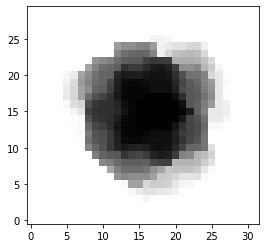

In [28]:
#
# Assumed input FWHM=1.0"
#
FWHM_in = 1.5
sigma_FWHM=FWHM_in/pix_size/2.354
new_radius=1
aper = CircularAperture(points_WCS, radius)
new_aper = CircularAperture(points_WCS, new_radius)
#aper_center = CircularAperture(points_WCS, new_radius)
img_Gauss=Gaussian2D_map(nx,ny,1,nx*0.5,ny*0.5,sigma_FWHM,sigma_FWHM,0)
phot_Gauss_org = aperture_photometry(img_Gauss, aper,\
                                           method='subpixel',subpixels=5)
img_Gauss_r,weights_Gauss_r = inter_map_IDW(phot_Gauss_org,radius,[0,0],[1,1],[nx,ny],sigma=sigma,\
                                            slope=slope,\
                            radius_limit=r_lim)
img_psf_r = img_Gauss_r[int(0.4*ny):int(0.6*ny),int(0.4*nx):int(0.6*nx)]
plt.imshow(np.log10(img_psf_r), cmap='gray_r', vmin=-10, vmax=-1, origin='lower')

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/sanchez/.local/lib/python3.8/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]


CDELT_ORG = [6.94444461e-05 6.94444461e-05]
xc_PS= 240.0 240.0 288 288
flux_ratio = 2.308850823739632e-05
WCS_input= 71 61
IN=  143.02611139053542 8.44126148169516
OUT =  143.02616537274028 8.440726271191686
photometric correction
pix_rat = 0.5000000121071928
16647
rat = 0.9697871623553722+-0.3750355672556058
filter=r, mag_PS = 11.91738056899177, mag_PS_to_CAL = 10.41747287948986, mag_CAL = 10.394832000701673
sigma_psf = 1.7500000000000007 pixels, chi_min=19.21857425294059
FWHM_now = 2.089275008824832 arcsec


<ipython-input-4-fdef43e42c54>:131: RuntimeWarning: divide by zero encountered in true_divide
  chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
<ipython-input-4-fdef43e42c54>:154: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:160: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:162: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e

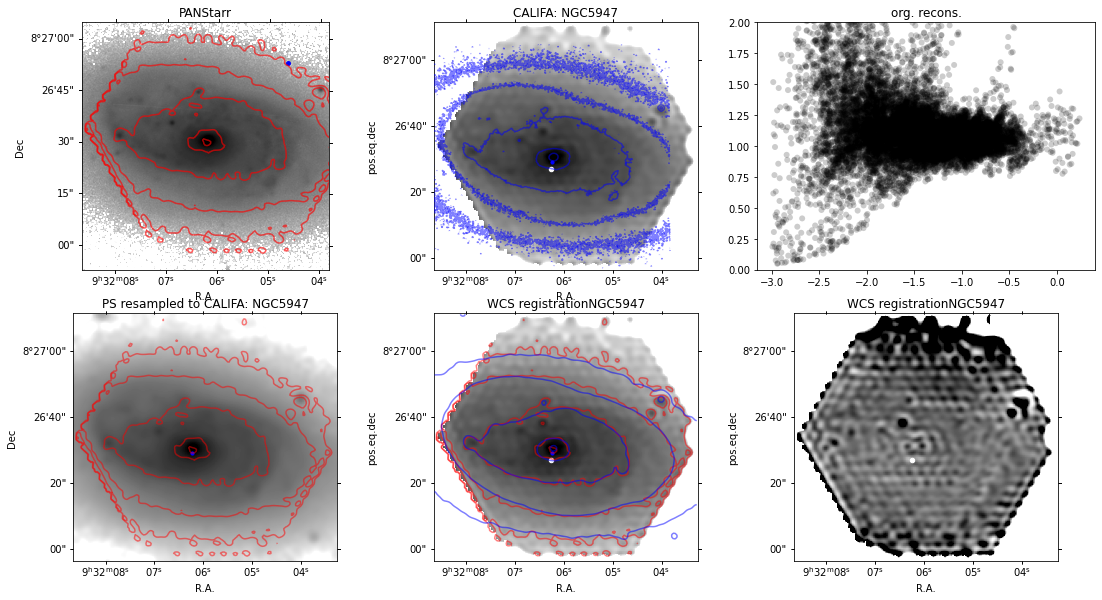

In [29]:
ext='png'
band='r'
i_range=5
filename_PS_r = f'{name}_PS_warp_{band}.fits'
img_dec_r = deconv_img(img_r,aper,FWHM_input=0.5,slope=slope,smooth=1,clip=True,filter_epsilon=0.00005)
(crval1_cal,crval2_cal,\
 crpix1_cal,crpix2_cal,e_crval1_cal,\
 e_crval2_cal,rat_mean,rat_std,mag_PS,\
 mag_PS_to_CAL,mag_CAL,FWHM_now,chi_now,rat_map)=get_astrometry(img_dec_r,filename_PS_r,ext=ext, xc_PS=df_s['XC1'][0],yc_PS=df_s['YC1'][0],RA_PS=df_s['CRVAL1_CR'][0] , DEC_PS=df_s['CRVAL2_CR'][0], xc_cal=df_s['XC'][0]/pix_size-2*radius , yc_cal=df_s['YC'][0]/pix_size-2*radius,band=band,i_range=i_range,label='org. recons.',FWHM_in=0.7,A_R=Ar_name)


In [30]:
n_mc=10
plot=0

cube_dec=cube_org.copy()
cube_err=cube_org.copy()
(nz_c,ny_c,nx_c)=cube_dec.shape
nz_0=0
nz_1=nz_c

f_e = 0.005

#nz_0=1132
#nz_1=1135
#plot=1

for iz in arange(nz_0,nz_1):
    cube_mc = np.zeros([n_mc,ny_c,nx_c],dtype=np.float32)
    for i_mc in arange(0,n_mc):
        img_org=cube_org[iz,:,:]+gaussian_filter(np.sqrt(cube_var[iz,:,:]),sigma=fsize/pix_size)*(np.random.random([ny_c,nx_c])-0.5)
        if (iz==0):
            img_psf_r=deconv_get_psf(img_org,aper,FWHM_input=1)
        img_loop_dec=deconv_img_psf(img_org,img_psf_r,FWHM_input=1,smooth=0,clip=True,filter_epsilon=f_e)       
        flux_ratio = np.sum(img_org)/np.sum(img_loop_dec)
        img_loop_dec = img_loop_dec*flux_ratio
        img_loop_dec[img_org==0]=0       
        cube_mc[i_mc,:,:]=img_loop_dec
    cube_dec[iz,:,:]=np.nanmean(cube_mc,axis=0)
    cube_err[iz,:,:]=np.nanstd(cube_mc,axis=0)
    print(f'{iz}',end='\r')
    if (plot==1):
        fig,ax = plt.subplots(1,2,figsize=(10,8))
        ax[0].imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
        ax[0].set_xlim([0*nx,1.0*nx])
        ax[0].set_ylim([0*ny,1.0*ny])
        ax[1].imshow(np.log10(img_loop_dec), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
        ax[1].set_xlim([0*nx,1.0*nx])
        ax[1].set_ylim([0*ny,1.0*ny])
        plt.show()


<ipython-input-3-d820ac4895af>:229: RuntimeWarning: invalid value encountered in double_scalars
  flux_ratio = np.sum(img_center)/np.sum(img_loop_dec)
<ipython-input-30-5e4c6d98aa4b>:23: RuntimeWarning: invalid value encountered in double_scalars
  flux_ratio = np.sum(img_org)/np.sum(img_loop_dec)


In [31]:
cube_cl_dec = Cube(data=cube_dec,wave=wavelength,header=hdr)
img_u_dec = passband_u.getFluxCube(cube_cl_dec)[0]
img_g_dec = passband_g.getFluxCube(cube_cl_dec)[0]
img_r_dec = passband_r.getFluxCube(cube_cl_dec)[0]

cube_cl_err = Cube(data=cube_err,wave=wavelength,header=hdr)
img_u_err = passband_u.getFluxCube(cube_cl_err)[0]
img_g_err = passband_g.getFluxCube(cube_cl_err)[0]
img_r_err = passband_r.getFluxCube(cube_cl_err)[0]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/sanchez/.local/lib/python3.8/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]


CDELT_ORG = [6.94444461e-05 6.94444461e-05]
xc_PS= 240.0 240.0 288 288
flux_ratio = 2.308850823739632e-05
WCS_input= 75 65
IN=  143.0261141683132 8.44125870391738
OUT =  143.0257753553792 8.441282304177799
photometric correction
pix_rat = 0.5000000121071928
16675
rat = 1.1300011609098044+-0.2674617284036788
filter=r, mag_PS = 11.91738056899177, mag_PS_to_CAL = 10.415202951478879, mag_CAL = 10.389711951603573
sigma_psf = 1.2000000000000004 pixels, chi_min=27.637109915889084
FWHM_now = 1.4551198438616666 arcsec


<ipython-input-4-fdef43e42c54>:131: RuntimeWarning: divide by zero encountered in true_divide
  chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
<ipython-input-4-fdef43e42c54>:154: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:160: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:162: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e

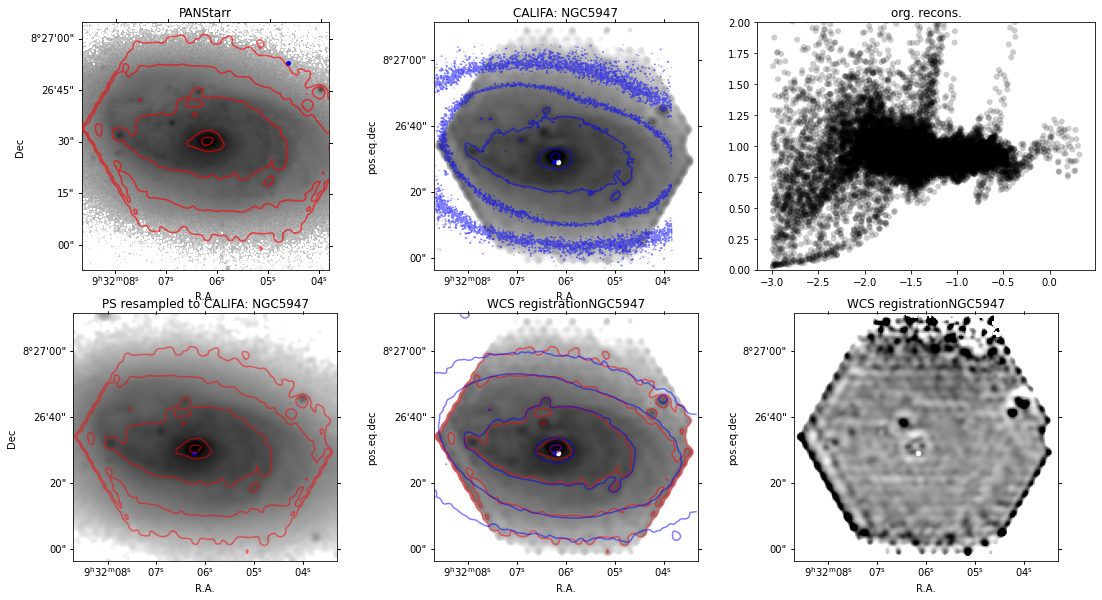

In [32]:
ext='png'
band='r'
i_range=5
filename_PS_r = f'{name}_PS_warp_{band}.fits'
(crval1_cal_r,crval2_cal_r,\
 crpix1_cal_r,crpix2_cal_r,e_crval1_cal_r,\
 e_crval2_cal_r,rat_mean_r,rat_std_r,mag_PS_r,\
 mag_PS_to_CAL_r,mag_CAL_r,FWHM_now_r,chi_now_r,rat_map_r)=get_astrometry(img_r_dec,filename_PS_r,ext=ext, xc_PS=df_s['XC1'][0],yc_PS=df_s['YC1'][0],RA_PS=df_s['CRVAL1_CR'][0] , DEC_PS=df_s['CRVAL2_CR'][0], xc_cal=df_s['XC'][0]/pix_size+radius , yc_cal=df_s['YC'][0]/pix_size+radius,band=band,i_range=i_range,label='org. recons.',FWHM_in=0.7,A_R=Ar_name)


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/sanchez/.local/lib/python3.8/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]


CDELT_ORG = [6.94444461e-05 6.94444461e-05]
xc_PS= 240.0 240.0 288 288
flux_ratio = 5.6223381184341856e-05
WCS_input= 71 61
IN=  143.02611139053542 8.44126148169516
OUT =  143.02638021649028 8.440593892719466
photometric correction
pix_rat = 0.5000000121071928
17168
rat = 0.9021437289967421+-1.9768743375319722
filter=g, mag_PS = 12.679359364745658, mag_PS_to_CAL = 11.17753401257222, mag_CAL = 10.977040269399765
sigma_psf = 1.4000000000000006 pixels, chi_min=76.1284365718803
FWHM_now = 1.6845607261241733 arcsec


<ipython-input-4-fdef43e42c54>:131: RuntimeWarning: divide by zero encountered in true_divide
  chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
<ipython-input-4-fdef43e42c54>:154: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:160: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:162: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e

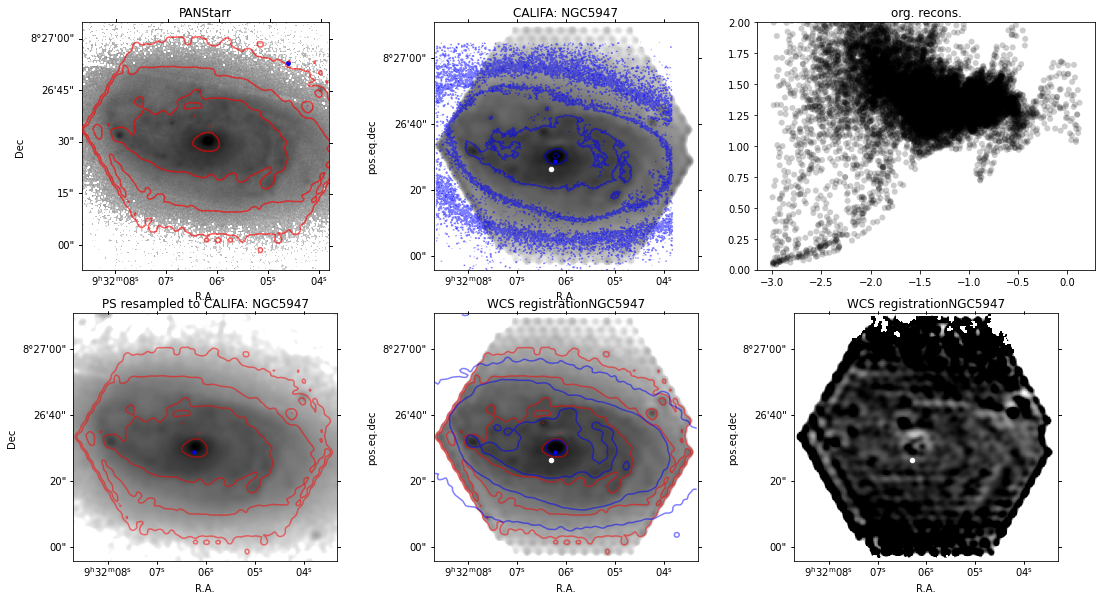

In [33]:
ext='png'
band='g'
i_range=5
filename_PS_g = f'{name}_PS_warp_{band}.fits'
(crval1_cal_g,crval2_cal_g,\
 crpix1_cal_g,crpix2_cal_g,e_crval1_cal_g,\
 e_crval2_cal_g,rat_mean_g,rat_std_g,mag_PS_g,\
 mag_PS_to_CAL_g,mag_CAL_g,\
 FWHM_now_g,chi_now_g,rat_map_g)=get_astrometry(img_g_dec,filename_PS_g,ext=ext, xc_PS=df_s['XC1'][0],yc_PS=df_s['YC1'][0],RA_PS=df_s['CRVAL1_CR'][0] , DEC_PS=df_s['CRVAL2_CR'][0], xc_cal=df_s['XC'][0]/pix_size-2*radius , yc_cal=df_s['YC'][0]/pix_size-2*radius,band=band,i_range=i_range,label='org. recons.',FWHM_in=0.7,A_R=Ag_name)


In [34]:
# Using the g-band ratio produces images of poorer quality!
#rat_map = 0.5 * (rat_map_g+rat_map_r)
rat_map=rat_map_r

print(f'RAT: g=={rat_mean_g}+-{rat_std_g} ; r=={rat_mean_r}+-{rat_std_r}')
print(f'FWHM: g=={FWHM_now_g}; r=={FWHM_now_r}')
hdr=hdu_rss[0].header.copy()
hdr['CRVAL3']=hdu_rss[0].header['CRVAL1']
hdr['CRPIX3']=hdu_rss[0].header['CRPIX1']
hdr['CDELT3']=hdu_rss[0].header['CDELT1']
hdr['CRVAL1']=crval1_cal_r
hdr['CRPIX1']=crpix1_cal_r
hdr['CDELT1']=pix_size
hdr['CRVAL2']=crpix2_cal_r
hdr['CRPIX2']=crval2_cal_r
hdr['CDELT2']=pix_size
hdr['CD1_1']=pix_size/3600
hdr['CD1_2']=0.0
hdr['CD1_3']=0.0
hdr['CD2_1']=0.0
hdr['CD2_2']=pix_size/3600
hdr['CD2_3']=0.0
hdr['CD3_1']=0.0
hdr['CD3_2']=0
hdr['CD3_3']=hdu_rss[0].header['CDELT1']
hdr['CTYPE1']='RA---TAN' 
hdr['CTYPE2']='DEC--TAN' 
hdr['CTYPE3']='WAVELENGTH' 
hdr['CUNIT1']='deg'
hdr['CUNIT2']='deg' 
hdr['CUNIT3']='Angstrom'
hdr['RAT_PS_G']=rat_mean_g
hdr['STD_PS_G']=rat_std_r
hdr['RAT_PS_R']=rat_mean_r
hdr['STD_PS_R']=rat_std_r
rat_mean = 0.5*(rat_mean_r+rat_mean_g)
std_mean = sqrt((rat_std_r**2+rat_std_g**2)/2)
hdr['RAT_PS']=rat_mean
hdr['STD_PS']=rat_std


RAT: g==0.9021437289967421+-1.9768743375319722 ; r==1.1300011609098044+-0.2674617284036788
FWHM: g==1.6845607261241733; r==1.4551198438616666


In [35]:
xc_h=nx/2
yc_h=ny/2
r_h=90/2/pix_size
a=0.5*r_h
b=(np.sqrt(3)/2)*r_h
poly_verts = [(-r_h+xc_h,yc_h), (-a+xc_h,b+yc_h), (a+xc_h,b+yc_h),(r_h+xc_h,0+yc_h),(a+xc_h,-b+yc_h),(-a+xc_h,-b+yc_h)]
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points_h = np.vstack((x,y)).T
path_h = mpl_path(poly_verts)
grid_h = path_h.contains_points(points_h)
grid_h = grid_h.reshape((ny,nx))

<ipython-input-36-80cda21fd390>:6: RuntimeWarning: divide by zero encountered in true_divide
  SN_map_g = img_g_dec/img_g_err
<ipython-input-36-80cda21fd390>:6: RuntimeWarning: invalid value encountered in true_divide
  SN_map_g = img_g_dec/img_g_err
<ipython-input-36-80cda21fd390>:14: RuntimeWarning: divide by zero encountered in true_divide
  rat_map_inv = 1/rat_map


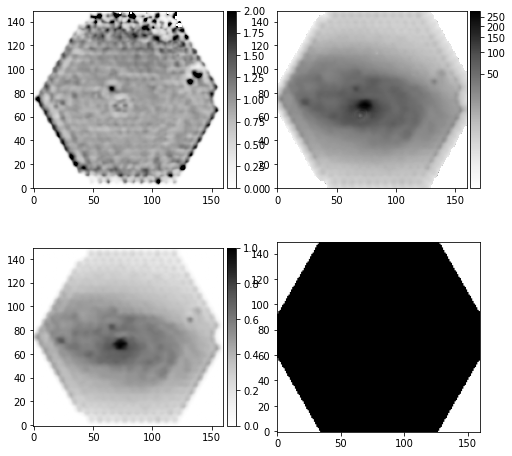

In [36]:
#print(rat_map.shape)

#
# S/N map
#
SN_map_g = img_g_dec/img_g_err

#points_inside_poly


mask_good_pix = (SN_map_g<1) | (img_g_dec< 0.2*f_e) #| (rat_map>1.5) | (rat_map<0.1)
#mask_good_pix = (SN_map_g<0.5) | (img_g_dec< 0.5*f_e) | (rat_map>4) | (rat_map<1/4)
#mask_good_pix = grid_h # | (SN_map_g<0.5) | (img_g_dec< 0.1*f_e)
rat_map_inv = 1/rat_map
rat_map_inv[mask_good_pix]=1
rat_map_inv = rat_map_inv*rat_mean
rat_map_inv[~grid_h]=0


fig,ax=subplots(2,2,figsize=(8,8))
im0=ax[0][0].imshow(rat_map, vmin=0,vmax=2,cmap='Greys', origin='lower')
im1=ax[0][1].imshow(SN_map_g, cmap='Greys',norm=PowerNorm(0.25), origin='lower')
im2=ax[1][0].imshow(img_g_dec, cmap='Greys',norm=PowerNorm(0.25), origin='lower')
im2=ax[1][1].imshow(grid_h, cmap='Greys', origin='lower')

div0 = make_axes_locatable(ax[0][0])
cax0 = div0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')

div1 = make_axes_locatable(ax[0][1])
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

div2 = make_axes_locatable(ax[1][0])
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')


In [37]:
cube_dec_flat=cube_dec*rat_map_inv
primhdu = fits.PrimaryHDU(data=cube_dec_flat,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.dcube_new.fits.gz'
hdulist.writeto(outfile,overwrite=True)
print('DONE')

DONE


In [38]:
wcs = WCS(hdr)

In [39]:
print(wcs)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVELENGTH'  
CRVAL : 143.0257753553792  65.0  3749.0  
CRPIX : 75.0  8.441282304177799  1.0  
CD1_1 CD1_2 CD1_3  : 0.000138888888888888  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000138888888888888  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  2.0  
NAXIS : 1877  993


# FURTHER TESTS BELOW!

In [40]:
#
# FWHM of the original CALIFA data
#
file_rscube = f'{fdir}/{name}.V500.rscube.fits.gz'
hdu_rscube=fits.open(file_rscube)
rscube = hdu_rscube[0].data
idx_r = np.abs(wavelength - 6215).argmin()
print(idx_r)
i0=idx_r-100
i1=idx_r+100
img_r_rscube = np.mean(rscube[i0:i1,:,:],axis=0)



1233


CDELT_ORG = [6.94444461e-05 6.94444461e-05]
xc_PS= 240.0 240.0 288 288
flux_ratio = 2.308850823739632e-05
WCS_input= 37 32
IN=  143.02613639053544 8.441236481695158


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/home/sanchez/.local/lib/python3.8/site-packages/image_registration/fft_tools/zoom.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  outarr[ii] = outarr_d[dims]
<ipython-input-4-fdef43e42c54>:131: RuntimeWarning: divide by zero encountered in true_divide
  chi_map = (img_PS_to_CAL-hdu.data)**2/hdu.data


OUT =  143.02591449383405 8.4413596370771
photometric correction
pix_rat = 0.2500000060535964
4397
rat = 0.9201217539953069+-0.20016429235112615
filter=r, mag_PS = 11.91738056899177, mag_PS_to_CAL = 11.919888631059298, mag_CAL = 11.986077347404606
sigma_psf = 1.3500000000000005 pixels, chi_min=0.6685249703429783
FWHM_now = 3.254081807514987 arcsec


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
<ipython-input-4-fdef43e42c54>:154: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(hdu_PS.data), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:160: RuntimeWarning: invalid value encountered in log10
  ax3.imshow(np.log10(img_PS_to_CAL), cmap='gray_r',vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:162: RuntimeWarning: divide by zero encountered in log10
  ax2.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, origin='lower')
<ipython-input-4-fdef43e42c54>:180: RuntimeWarning: divide by zero encountered in log10
  fig_img=ax4.imshow(np.log10(hdu.data), cmap='gray_r', vmin=vmin, vmax=vmax, o

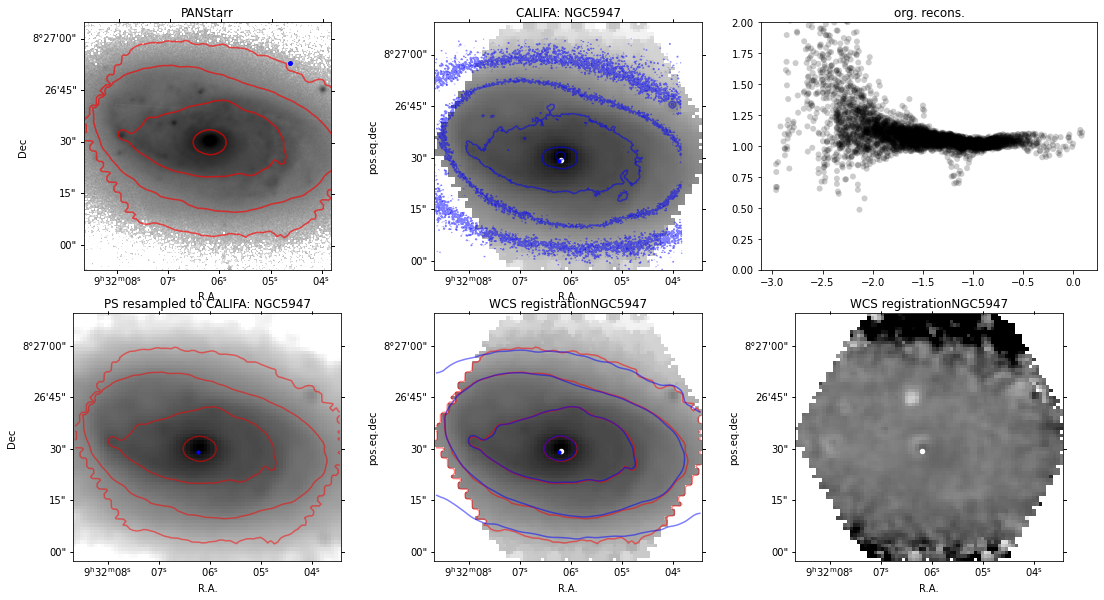

In [41]:
ext='png'
band='r'
i_range=5
filename_PS_r = f'{name}_PS_warp_{band}.fits'
(r_crval1_cal,r_crval2_cal,\
 r_crpix1_cal,r_crpix2_cal,r_e_crval1_cal,\
 r_e_crval2_cal,r_rat_mean,r_rat_std,r_mag_PS,\
 r_mag_PS_to_CAL,r_mag_CAL,r_FWHM_now,r_chi_now,rat_map)=get_astrometry(img_r_rscube/1.5,filename_PS_r,ext=ext, xc_PS=df_s['XC1'][0],yc_PS=df_s['YC1'][0],RA_PS=df_s['CRVAL1_CR'][0] , DEC_PS=df_s['CRVAL2_CR'][0], xc_cal=df_s['XC'][0], yc_cal=df_s['YC'][0],band=band,i_range=i_range,label='org. recons.',FWHM_in=0.7,A_R=Ar_name,new_pix=1.0)

In [42]:
print('RESULTS = ',r_rat_mean,r_rat_std,r_mag_PS,r_mag_PS_to_CAL,r_mag_CAL,r_FWHM_now,r_chi_now)

RESULTS =  0.9201217539953069 0.20016429235112615 11.91738056899177 11.919888631059298 11.986077347404606 3.254081807514987 0.6685249703429783


In [43]:


#
# Tests using a flat... it did not work!
#

In [44]:
#
# Other method
#
n0 = int(0.45*nz_c)
n1 = int(0.55*nz_c)
img_slice = rss_data[:,n0:n1].sum(axis=1)/(n1-n0)
phot_table=Table()
phot_table.add_column(pt_x_spax,name='xcenter')
phot_table.add_column(pt_y_spax,name='ycenter')
phot_table.add_column(img_slice,name='aperture_sum')
radius=fsize
img_org,weights = inter_map_IDW(phot_table,radius,[0,0],[1,1],[nx_c,ny_c],slope=slope,\
                            radius_limit=3.5/pix_size)

<ipython-input-45-77dde0de97df>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-1, origin='lower')


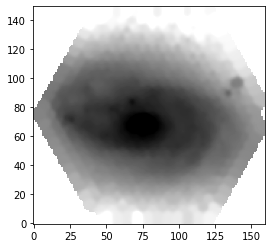

In [45]:
plt.imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-1, origin='lower')

<ipython-input-46-d7fa934207a2>:12: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
<ipython-input-46-d7fa934207a2>:15: RuntimeWarning: divide by zero encountered in log10
  ax[1].imshow(np.log10(img_loop_dec), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')


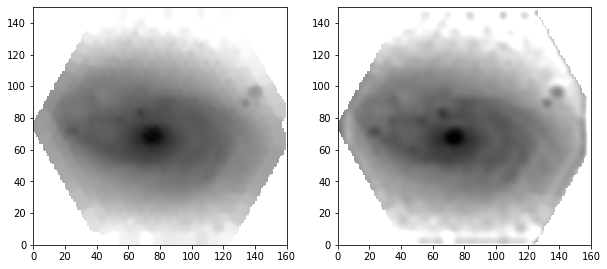

In [46]:
img_org_copy=img_org.copy()
img_org_copy[img_org_copy==0]=0.5*np.median(img_org[img_org>0])
img_loop_in = img_org_copy+img_org_copy.max() * 1E-5 * np.random.random(img_org_copy.shape)
img_loop_dec = restoration.richardson_lucy(img_loop_in, img_psf_r,10)#, num_iter=30)
img_loop_dec = gaussian_filter(img_loop_dec,sigma=0.5)#*np.sum(img_Gauss)
flux_ratio = np.sum(img_loop_in)/np.sum(img_loop_dec)
img_loop_dec = img_loop_dec*flux_ratio
img_loop_dec[img_org==0]=0
cube_dec[iz,:,:]=img_loop_dec
print(f'{iz}',end='\r')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(np.log10(img_org), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
ax[0].set_xlim([0*nx,1.0*nx])
ax[0].set_ylim([0*ny,1.0*ny])
ax[1].imshow(np.log10(img_loop_dec), cmap='gray_r', vmin=-3, vmax=-0.5, origin='lower')
ax[1].set_xlim([0*nx,1.0*nx])
ax[1].set_ylim([0*ny,1.0*ny])
plt.show()

In [47]:
flat_img = img_loop_dec/img_org
flat_img[img_org==0]=0
cube_flatted = cube_org*flat_img
primhdu = fits.PrimaryHDU(data=cube_flatted,header=hdr)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.fcube.fits.gz'
hdulist.writeto(outfile,overwrite=True)
#flat_cube=np.ones([dim[2],dim[1],dim[0]],dtype=np.float32)
#flat_cube=cube_weights*weights


<ipython-input-47-969bc961589f>:1: RuntimeWarning: invalid value encountered in true_divide
  flat_img = img_loop_dec/img_org


In [48]:
primhdu = fits.PrimaryHDU(data=img_org_copy)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.img_org.fits.gz'
hdulist.writeto(outfile,overwrite=True)

In [49]:
primhdu = fits.PrimaryHDU(data=img_loop_dec)
hdulist=fits.HDUList([primhdu])
outfile=f'out/{name}.img_loop_dec.fits.gz'
hdulist.writeto(outfile,overwrite=True)